In [8]:
# Install dependencies
%pip install transformers torch pandas numpy matplotlib seaborn scikit-learn networkx umap-learn einops

# %% Step 1: Imports
import torch
from transformers import AutoTokenizer, AutoModel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import DBSCAN
import seaborn as sns
import networkx as nx
import random


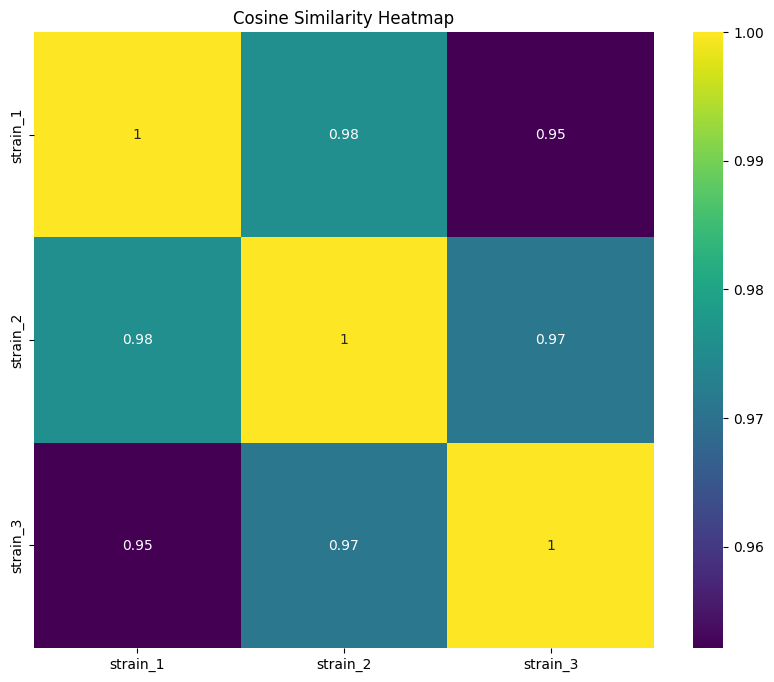

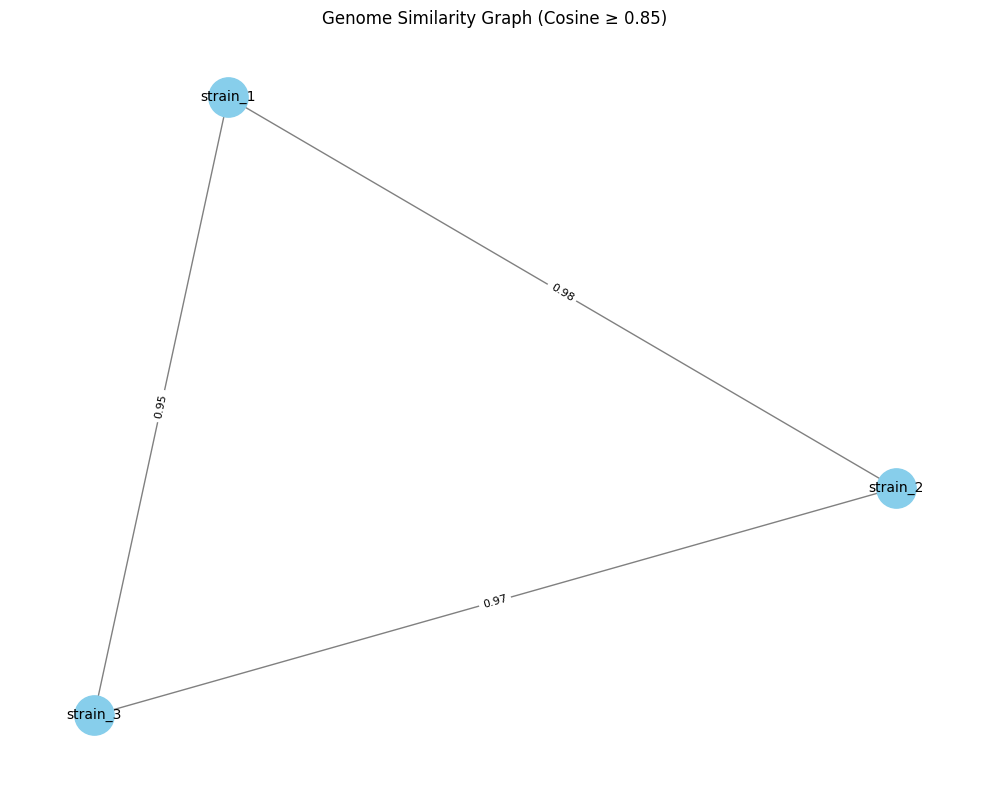

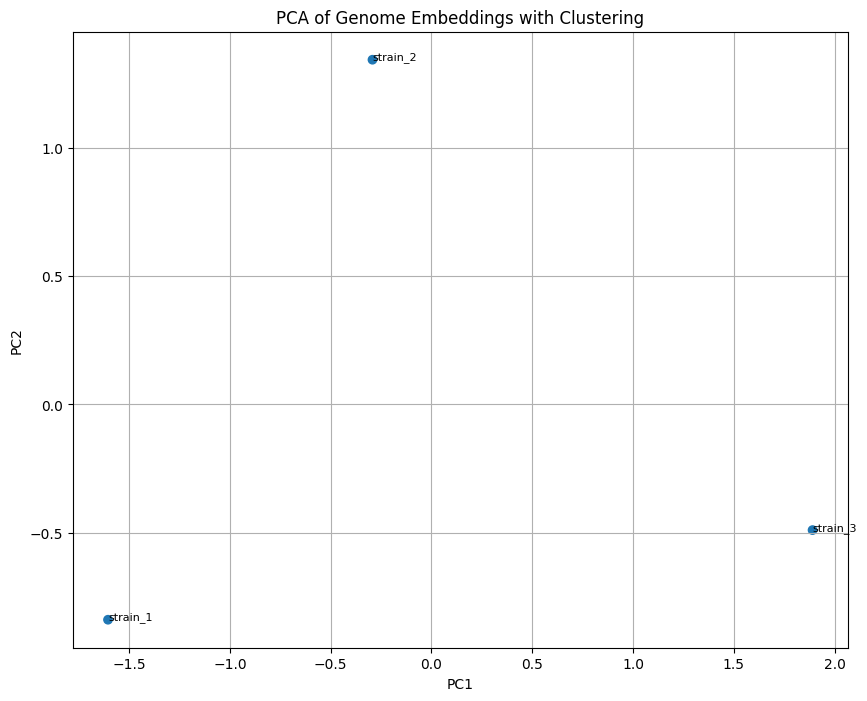

In [9]:
# %% Step 2: Load DNA-BERT model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("zhihan1996/DNA_bert_6")
model = AutoModel.from_pretrained("zhihan1996/DNA_bert_6")
model.eval()

# %% Step 3: Function to parse FASTA files
def parse_fasta(file_path):
    """Parse a FASTA file and return all sequences as a list of strings."""
    with open(file_path) as f:
        seq = []
        for line in f:
            line = line.strip()
            if not line or line.startswith(">"):
                continue
            seq.append(line)
        return seq

# %% Step 4: File paths and load sequences
file_paths = [
r"C:\Users\yalin\OneDrive\Desktop\MRes\A Nosocomial Project\Test Transformer\Freundii Test\Data\234098wB12_CPE0002665_assembly_filtered.fasta",
r"C:\Users\yalin\OneDrive\Desktop\MRes\A Nosocomial Project\Test Transformer\Freundii Test\Data\234098wD4_CPE0002596_assembly_filtered.fasta",
r"C:\Users\yalin\OneDrive\Desktop\MRes\A Nosocomial Project\Test Transformer\Freundii Test\Data\234098wA8_CPE0002631_assembly_filtered.fasta",
]
headers = [f"strain_{i+1}" for i in range(len(file_paths))]
sequences = [parse_fasta(fp)[0] for fp in file_paths]

# %% Step 5: DNA-BERT embedding function
def seq_to_kmers(seq, k=6):
    return ' '.join([seq[i:i+k] for i in range(len(seq)-k+1)])

def get_dnabert_embedding(sequence, k=6):
    kmer_seq = seq_to_kmers(sequence, k)
    tokens = tokenizer(kmer_seq, return_tensors="pt", truncation=True, padding="max_length", max_length=512)
    input_ids = tokens["input_ids"]
    attention_mask = tokens["attention_mask"]
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)
        embeddings = outputs.last_hidden_state
        mask = attention_mask.unsqueeze(-1)
        masked_embeddings = embeddings * mask
        mean_embedding = masked_embeddings.sum(dim=1) / mask.sum(dim=1)
        return mean_embedding.squeeze().cpu().numpy()

# %% Step 6: Generate embeddings
embeddings = [get_dnabert_embedding(seq) for seq in sequences]

# %% Step 7: Create dataframe
df_all = pd.DataFrame({
    'Header': headers,
    'embedding': embeddings
})

# %% Step 8: Cosine similarity matrix
X = np.stack(df_all['embedding'].values)
similarity_matrix = cosine_similarity(X)

# %% Step 9: Visualize similarity matrix
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, xticklabels=df_all['Header'], yticklabels=df_all['Header'], annot=True, cmap='viridis')
plt.title("Cosine Similarity Heatmap")
plt.show()

# %% Step 10: DBSCAN clustering
clustering = DBSCAN(eps=0.1, min_samples=2, metric='cosine').fit(X)
df_all['Cluster'] = clustering.labels_

# %% Step 11: Similarity graph
threshold = 0.85
G = nx.Graph()
for i, label_i in enumerate(df_all['Header']):
    G.add_node(label_i)
    for j in range(i+1, len(df_all)):
        if similarity_matrix[i][j] >= threshold:
            G.add_edge(label_i, df_all['Header'][j], weight=similarity_matrix[i][j])
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)
nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=800)
nx.draw_networkx_edges(G, pos, edge_color='gray')
nx.draw_networkx_labels(G, pos, font_size=10)
edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
plt.title("Genome Similarity Graph (Cosine ≥ 0.85)")
plt.axis('off')
plt.tight_layout()
plt.show()

# %% Step 12: PCA visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
jitter = np.random.normal(0, 0.01, X_pca.shape)
X_pca_jittered = X_pca + jitter
unique_clusters = sorted(df_all['Cluster'].unique())
color_map = {cluster: plt.cm.tab10(i % 10) for i, cluster in enumerate(unique_clusters)}
colors = [color_map[c] for c in df_all['Cluster']]
plt.figure(figsize=(10, 8))
plt.scatter(X_pca_jittered[:,0], X_pca_jittered[:,1], c=colors)
for i, label in enumerate(df_all['Header']):
    plt.text(X_pca_jittered[i,0], X_pca_jittered[i,1], label, fontsize=8)
plt.title("PCA of Genome Embeddings with Clustering")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()


In [10]:
# %% Step 13: Print first 10 values of each embedding
for header, emb in zip(df_all['Header'], df_all['embedding']):
    print(f"\n{header} embedding (length {len(emb)}):")
    print(np.round(emb[:10], 4), "...")
    
# Convert list of arrays into a 2D array
emb_matrix = np.vstack(df_all['embedding'].values)

# Create DataFrame with labeled columns
emb_df = pd.DataFrame(emb_matrix, index=df_all['Header'])
print(emb_df.head())


strain_1 embedding (length 768):
[-0.2975  1.0101 -0.3993 -0.6752  0.1628 -0.2135  0.4277 -0.1568 -0.1237
  0.1412] ...

strain_2 embedding (length 768):
[-0.2743  0.8755 -0.3015 -0.733   0.1897 -0.2065  0.3787 -0.0704 -0.1486
  0.1366] ...

strain_3 embedding (length 768):
[-0.2186  0.6951 -0.2423 -0.4917  0.2641 -0.2395  0.3439 -0.1132 -0.1184
  0.3464] ...
               0         1         2         3         4         5    \
Header                                                                 
strain_1 -0.297451  1.010091 -0.399277 -0.675249  0.162830 -0.213514   
strain_2 -0.274331  0.875498 -0.301522 -0.732983  0.189719 -0.206499   
strain_3 -0.218586  0.695117 -0.242340 -0.491704  0.264078 -0.239524   

               6         7         8         9    ...       758       759  \
Header                                            ...                       
strain_1  0.427677 -0.156793 -0.123702  0.141159  ...  0.113087 -0.040401   
strain_2  0.378709 -0.070373 -0.148610  0.136